In [1]:
import csv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import backoff

# Replace with your own Spotify API credentials
client_id = ' '
client_secret = ' '

# Set up Spotipy client
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Read the input CSV file
with open('song_data_smaller.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    song_data = list(reader)

# Create a new list to store the enriched data
enriched_data = []

# Define a decorator to handle rate limit errors
@backoff.on_exception(backoff.expo, spotipy.exceptions.SpotifyException, max_tries=8)
def fetch_danceability(track_id):
    audio_features = sp.audio_features(tracks=[track_id])[0]
    return audio_features['danceability']

# Iterate through each song and fetch its danceability
for song in song_data:
    track_id = song['song_id'].split(':')[-1]
    try:
        danceability = fetch_danceability(track_id)
        song['danceability'] = danceability
        enriched_data.append(song)
    except spotipy.exceptions.SpotifyException as e:
        print(f"Error fetching danceability for song {song['song_name']}: {e}")
        continue

# Write the enriched data to a new CSV file
fieldnames = enriched_data[0].keys()
with open('enriched_song_data.csv', 'w', newline='') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(enriched_data)

print("Enriched data has been written to 'enriched_song_data.csv'")

Enriched data has been written to 'enriched_song_data.csv'


In [7]:
import csv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import backoff

# Replace with your own Spotify API credentials
client_id = ' '
client_secret = ' '

# Set up Spotipy client
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Read the input CSV file
with open('song_data_smaller.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    song_data = list(reader)

# Create a new list to store the enriched data
enriched_data = []

# Define a decorator to handle rate limit errors
@backoff.on_exception(backoff.expo, spotipy.exceptions.SpotifyException, max_tries=8)
def fetch_audio_features(track_id):
    audio_features = sp.audio_features(tracks=[track_id])[0]
    if not audio_features:
        return None
    # We return only the audio features
    return {
        'danceability': audio_features['danceability'],
        'energy': audio_features['energy'],
        'valence': audio_features['valence'],
        'tempo': audio_features['tempo'],
    }

@backoff.on_exception(backoff.expo, spotipy.exceptions.SpotifyException, max_tries=8)
def fetch_artist_popularity(artist_uri):
    artist_info = sp.artist(artist_uri)
    return artist_info['popularity']

# Iterate through each song and fetch its audio features and artist popularity
for song in song_data:
    track_id = song['song_id'].split(':')[-1]
    artist_uri = song['artist_uri']
    try:
        # Fetch audio features and artist popularity separately
        audio_features = fetch_audio_features(track_id)
        artist_popularity = fetch_artist_popularity(artist_uri)
        if audio_features and artist_popularity is not None:
            song.update(audio_features)
            song['artist_popularity'] = artist_popularity
            enriched_data.append(song)
        else:
            print(f"Data not found for song {song['song_name']}")
    except spotipy.exceptions.SpotifyException as e:
        print(f"Error fetching data for song {song['song_name']}: {e}")

# Write the enriched data to a new CSV file
fieldnames = ['song_id', 'song_name', 'artist_name', 'artist_uri', 'album_name', 'album_uri', 
              'danceability', 'energy', 'valence', 'tempo', 'artist_popularity']
with open('enriched_song_data.csv', 'w', newline='') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(enriched_data)

print("Enriched data has been written to 'enriched_song_data.csv'")


Enriched data has been written to 'enriched_song_data.csv'


In [3]:
import pandas as pd
import networkx as nx

# Load the enriched dataset
enriched_data = pd.read_csv('enriched_song_data.csv')

# Create a NetworkX graph from the enriched dataset
G = nx.Graph()
for _, row in enriched_data.iterrows():
    G.add_node(row['song_id'], danceability=row['danceability'])

# Calculate the average danceability for high-degree nodes (well-connected nodes)
degree_threshold = 10  # Adjust this value as needed
high_degree_nodes = [node for node, degree in G.degree() if degree >= degree_threshold]
high_degree_danceability = [G.nodes[node]['danceability'] for node in high_degree_nodes]
if high_degree_danceability:
    avg_high_degree_danceability = sum(high_degree_danceability) / len(high_degree_danceability)
else:
    avg_high_degree_danceability = 0

# Calculate the average danceability for low-degree nodes
low_degree_nodes = [node for node, degree in G.degree() if degree < degree_threshold]
low_degree_danceability = [G.nodes[node]['danceability'] for node in low_degree_nodes]
avg_low_degree_danceability = sum(low_degree_danceability) / len(low_degree_danceability)

# Print the results
print(f"Average danceability for high-degree nodes (degree >= {degree_threshold}): {avg_high_degree_danceability:.2f}")
print(f"Average danceability for low-degree nodes (degree < {degree_threshold}): {avg_low_degree_danceability:.2f}")

# Check the similarity between the two values
danceability_diff = abs(avg_high_degree_danceability - avg_low_degree_danceability)
print(f"\nDifference in average danceability between high-degree and low-degree nodes: {danceability_diff:.2f}")
if danceability_diff < 0.1:
    print("The danceability values are relatively similar among well-connected and less-connected nodes.")
else:
    print("There is a noticeable difference in danceability values among well-connected and less-connected nodes.")

Average danceability for high-degree nodes (degree >= 10): 0.00
Average danceability for low-degree nodes (degree < 10): 0.62

Difference in average danceability between high-degree and low-degree nodes: 0.62
There is a noticeable difference in danceability values among well-connected and less-connected nodes.


Average Degree Centrality: 0.053607660023902916
Average Betweenness Centrality: 0.0042973406345809696
Average Closeness Centrality: 0.3101372153947287
Average Eigenvector Centrality: 0.017964838787195632
Correlation between danceability and degree centrality: 0.007245832682315134


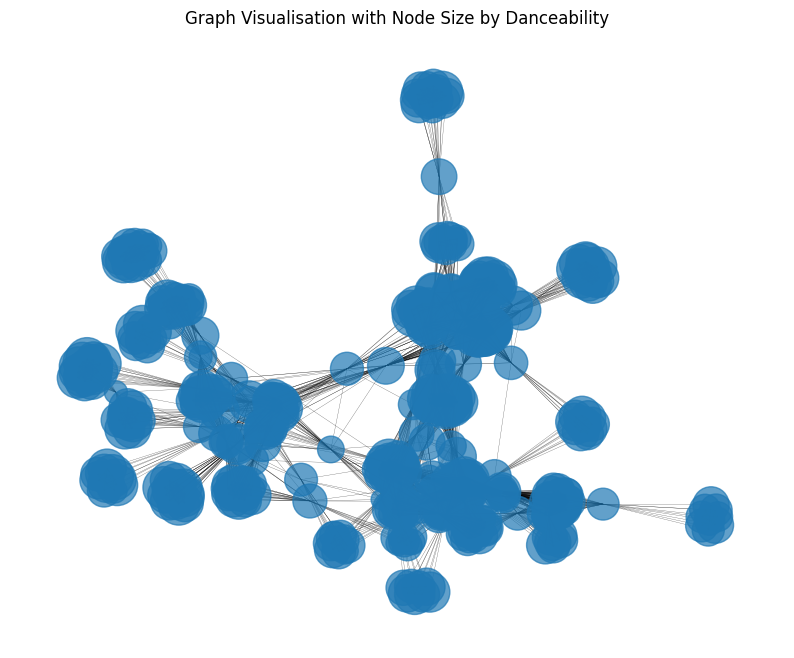

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the original network graph
G = pd.read_pickle("small_graph.pickle")

# Load the enriched song data with Spotify attributes
song_data = pd.read_csv('C:/Users/zaidc/OneDrive/UNI STUFF/Computer Science UG Year 3/Semester B/Digital Media and Social Networks/Spotify API Stuff/enriched_song_data.csv')



# Enrich the graph with the new attributes from the song data
for _, row in song_data.iterrows():
    if row['song_id'] in G:
        for col in song_data.columns:
            G.nodes[row['song_id']][col] = row[col]

# Calculate the centrality measures for the enriched graph
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=500)

# Calculate averages of centrality measures
nodes = G.number_of_nodes()
average_degree_centrality = sum(degree_centrality.values()) / nodes
average_betweenness_centrality = sum(betweenness_centrality.values()) / nodes
average_closeness_centrality = sum(closeness_centrality.values()) / nodes
average_eigenvector_centrality = sum(eigenvector_centrality.values()) / nodes

# Output centrality measures
print("Average Degree Centrality:", average_degree_centrality)
print("Average Betweenness Centrality:", average_betweenness_centrality)
print("Average Closeness Centrality:", average_closeness_centrality)
print("Average Eigenvector Centrality:", average_eigenvector_centrality)

# Correlation between 'danceability' and 'degree_centrality'
danceability_values = nx.get_node_attributes(G, 'danceability')
degree_centrality_values = nx.get_node_attributes(G, 'degree_centrality')

# Convert to lists and calculate correlation
danceability_list = list(danceability_values.values())
degree_centrality_list = [degree_centrality_values[node] for node in danceability_values.keys()]

correlation = pd.Series(danceability_list).corr(pd.Series(degree_centrality_list))
print("Correlation between danceability and degree centrality:", correlation)

# Calculate node sizes based on 'danceability' for visualization
sizes = [G.nodes[node]['danceability'] * 1000 for node in G.nodes() if 'danceability' in G.nodes[node]]

# Visualize the graph with node size based on 'danceability'
plt.figure(figsize=(10, 8))
plt.title("Graph Visualisation with Node Size by Danceability")
nx.draw(G, pos=nx.spring_layout(G), with_labels=False, node_size=sizes, font_weight='bold', alpha=0.7, width=0.2)
plt.show()
